# Amazon Fine Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review

Text - text of the review

Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

### Loading the data
The dataset is available in two forms

.csv file

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [74]:
# importing libraries 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
import os

In [75]:
import zipfile
dataset_path = "Reviews.sqlite.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [76]:
# using sqlite 3 read data 
con = sqlite3.connect('database.sqlite')

#Filtering only +ve and -ve reviews that is ignoring reviews with score !=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
LIMIT 5000
""",con)

def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'
    
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [77]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [78]:
filtered_data.shape

(5000, 10)

In [79]:
filtered_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### EDA 

Cleaning Data:- Removing duplicate rows

In [80]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score !=3 AND UserId = "AR5J8UI46CURR"
ORDER BY ProductId
""",con)

In [81]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


#### Observations:
As we can see in above table same user have given multiple reviews with same text,HelpfulnessNumerator and HelpfulnessDenominator at same time.

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on.

After analysis we found that reviews with same parameters with different ProductId belongs to same product and differ in only flavors. SO we will remove these dupliucates reviews

So first we will sort these reviews according to ProductId and then keep the first value and drop others.

In [82]:
# Sorting values according to Product Id
sorted_data = filtered_data.sort_values('ProductId',axis =0, ascending = True, inplace = False,kind = 'quicksort')
sorted_data.shape

(5000, 10)

In [83]:
# removing duplicate values 
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep = 'first',inplace=False)
final.shape

(4986, 10)

In [84]:
# cheching % of data left 
(final['Id'].size*1.0/filtered_data['Id'].size*1.0)*100

99.72

Aslo in our data HelpfulnessNumerator cannot be greater than HelpfulnessDenominator So also want to drop those rows

It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [85]:
# HelpfulnessNumerator --> Review helpful --> Yes
# HelpfulnessDenominator --> Review helpful --> Yes+No

display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score!= 3 AND Id = 44737 OR Id = 64422
ORDER BY ProductId
""",con)

display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [86]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,positive,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,positive,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,positive,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [87]:
final.shape

(4986, 10)

#### Observations:
We didn't have any row with HelpfulnessNumerator > HelpfulnessDenominator in our data of 5k points

## Text Preprocessing

In order to clean our text we will do following steps:

1:- Remove html tags from text

2:- Remove punctuations from text

3:- Check word is made up of alphabets only

4:- Check length of word is greater than 2

5:- Convert words to lowercase 

6:- Remove stopwords 

7:- Apply snowball stemming to the words 


In [88]:
# print some random variables 
sent_0 = final['Text'].values[0]
print(sent_0)
print("**"*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print('**'*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print('**'*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print('**'*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier t

In [89]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039

sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+","",sent_1000)
sent_1500 = re.sub(r"http\S+","", sent_1500)
sent_4900 = re.sub(r"http\S+","",sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [90]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0,'lxml')
text = soup.get_text()
print(text)


Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [91]:
soup = BeautifulSoup(sent_1000,'lxml')
text = soup.get_text()
print(text)
print('**'*50)

soup = BeautifulSoup(sent_1500,'lxml')
text = soup.get_text()
print(text)
print("**"*50)

soup = BeautifulSoup(sent_4900,'lxml')
text = soup.get_text()
print(text)

I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
****************************************************************************************************
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.These

In [92]:
# https://stackoverflow.com/a/47091490/4084039
import re 

def decontracted(phrase):
    #specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    # general
    phrase = re.sub(r"n'\t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [93]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you don not like that combination, don not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I don not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They aren not individually wrapped, which would add to the cost.  

In [94]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [95]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you don not like that combination don not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I don not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They aren not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if yo

In [96]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [97]:
# combining above
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar

for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "",sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ',sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1408.81it/s]


In [98]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [99]:
final['Score'].value_counts()

positive    4178
negative     808
Name: Score, dtype: int64

In [100]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,positive,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,positive,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...


In [101]:
# preprocessing summary
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from tqdm import tqdm
from bs4 import BeautifulSoup

stop = set(stopwords.words('english'))
preprocessed_summary = []
for sent in tqdm(final['Summary'].values):
    sent = re.sub(r"http\S+", "", sent)
    sent = BeautifulSoup(sent, 'lxml').get_text()
    sent = decontracted(sent) # from above decontracted function
    sent = re.sub("\S*\d\S*", "", sent).strip()
    sent = re.sub('[^A-Za-z]+', ' ', sent)
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stop)
    preprocessed_summary.append(sent.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:02<00:00, 1954.24it/s]


In [102]:
print(preprocessed_summary[1200])
print('=='*50)
print(preprocessed_summary[1000])
print('=='*50)
print(preprocessed_summary[500])
print('=='*50)
print(preprocessed_summary[1500])

good product
best sour cream onion chip
great healthy snack
reviewing mistakes cookies


## Featurization

###  Bag Of Words

In [103]:
count_vect = CountVectorizer()
count_vect.fit(preprocessed_reviews)
print("Some Feature names: ", count_vect.get_feature_names()[:10])
print("**"*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("Type of count Vectorizer: ", type(final_counts))
print("Shape of text BOW vectorizer: ",final_counts.shape)

Some Feature names:  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
****************************************************************************************************
Type of count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
Shape of text BOW vectorizer:  (4986, 12997)


### Bi-Gram

In [104]:
count_vect = CountVectorizer(ngram_range =(1,2), min_df = 10, max_features = 5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("Type of count Vectorizer: ", type(final_bigram_counts))
print("Shape of text BiGram vectorizer: ",final_bigram_counts.shape)

Type of count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
Shape of text BiGram vectorizer:  (4986, 3144)


### TF-IDF

In [105]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2),min_df = 10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)


### Word2Vec

In [106]:
# Train your own Word2Vec model using our own text corpus
i = 0
list_of_sentence = []
for sentence in preprocessed_reviews:
    list_of_sentence.append(sentence.split())

In [107]:
w2v_model = Word2Vec(list_of_sentence, min_count = 5, size = 50, workers=4)
print(w2v_model.wv.most_similar('great'))
print("**"*50)
print(w2v_model.wv.most_similar('worst'))

[('snack', 0.995121955871582), ('absolutely', 0.9949893355369568), ('crisp', 0.9947600364685059), ('chewy', 0.9947245717048645), ('want', 0.9945630431175232), ('alternative', 0.9945617914199829), ('excellent', 0.9945465326309204), ('thai', 0.9944016337394714), ('satisfying', 0.9943647384643555), ('enjoy', 0.9943505525588989)]
****************************************************************************************************
[('awful', 0.9994101524353027), ('stash', 0.9993828535079956), ('exactly', 0.9993572235107422), ('terrible', 0.9993543028831482), ('peanuts', 0.9993260502815247), ('part', 0.9993112683296204), ('enjoyed', 0.999310314655304), ('hit', 0.9993013143539429), ('impressed', 0.9992918372154236), ('stand', 0.9992904663085938)]


In [108]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("\nSample words: ",w2v_words[0:50])

number of words that occured minimum 5 times  3815

Sample words:  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made', 'two']


## Converting Text into vectors using AvgW2V, TF_IDF-W2V

### Avg W2V

In [109]:
# compute average word2vec for each review
sent_vectors = [] # avg-w2v for each review stored in this list
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50) 
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words +=1
    if cnt_words !=0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:07<00:00, 650.47it/s]

4986
50


### TFIDF Weigted W2V

In [110]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are creating a dictionary with word as key and idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [111]:
# TDIDF weighted Word2Vec
tfidf_feat = model.get_feature_names() #tfidf features/columns

tfidf_sent_vectors = []
row = 0
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduxe computation:
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec*tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:48<00:00, 103.78it/s]


## Applying TSNE

### Applying TSNE on Text BOW


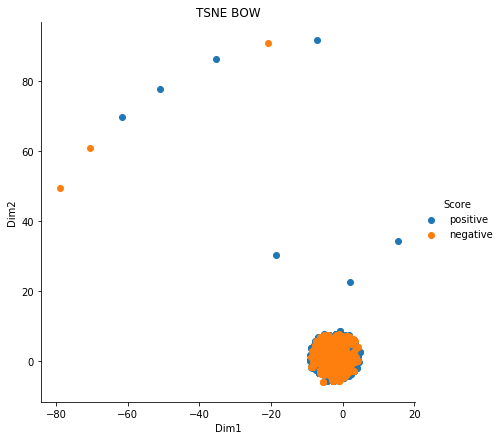

In [112]:
from sklearn.manifold import TSNE
import seaborn as sns

score = final['Score']
final_counts = final_counts.todense()

model = TSNE(n_components =2, random_state =0, perplexity = 50, n_iter = 5000)
tsne_data = model.fit_transform(final_counts)
tsne_data = np.vstack((tsne_data.T,score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns = ("Dim1","Dim2","Score"))
sns.FacetGrid(tsne_df, hue="Score", size= 6).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title("TSNE BOW")
plt.show()

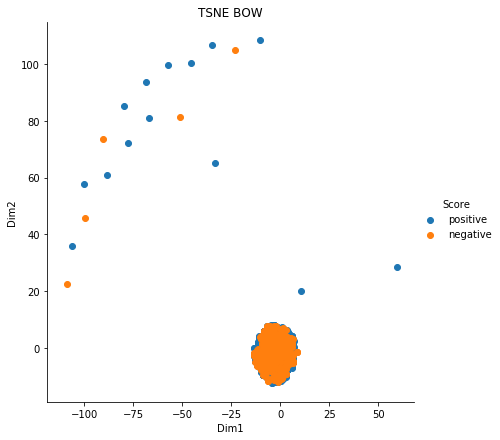

In [114]:
model = TSNE(n_components = 2,random_state = 0, perplexity = 30, n_iter = 3000)
tsne_data = model.fit_transform(final_counts)
tsne_data = np.vstack((tsne_data.T,score)).T
tsne_df = pd.DataFrame(data = tsne_data, columns=("Dim1","Dim2","Score"))
sns.FacetGrid(tsne_df,hue="Score",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("TSNE BOW")
plt.show()

#### Observation:-

TSNE is unable to seperate positive and negative reviews as most of them are overlapping.

### Applying TSNE on TFIDF vectors

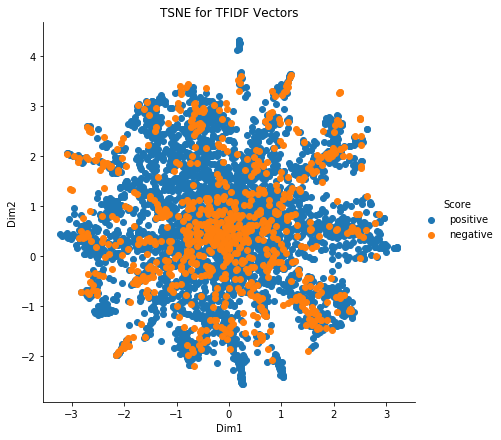

In [115]:
from sklearn.manifold import TSNE
import seaborn as sns
score = final['Score']
model = TSNE(n_components = 2, random_state = 0, perplexity = 35, n_iter = 5000)
final_tf_idf = final_tf_idf.todense()
tsne_data = model.fit_transform(final_tf_idf)
tsne_data = np.vstack((tsne_data.T,score)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=("Dim1","Dim2","Score"))

sns.FacetGrid(tsne_df,hue='Score',size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("TSNE for TFIDF Vectors")
plt.show()

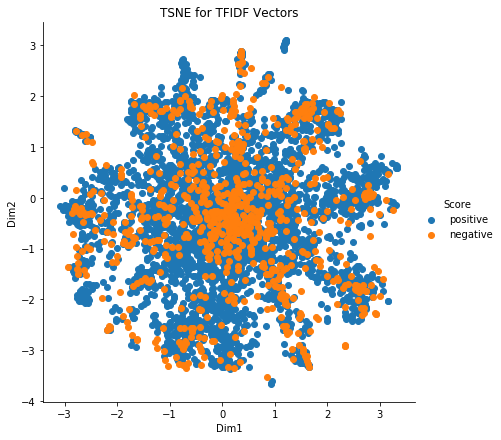

In [116]:
model = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=3000)
tsne_data = model.fit_transform(final_tf_idf)
tsne_data = np.vstack((tsne_data.T,score)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=("Dim1","Dim2","Score"))

sns.FacetGrid(tsne_df,hue='Score',size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.title("TSNE for TFIDF Vectors")
plt.show()

#### Obervation:-
TSNE is still unable to seperate positive and negative reviews

### Applying TSNE on Text AvgW2V Vectors

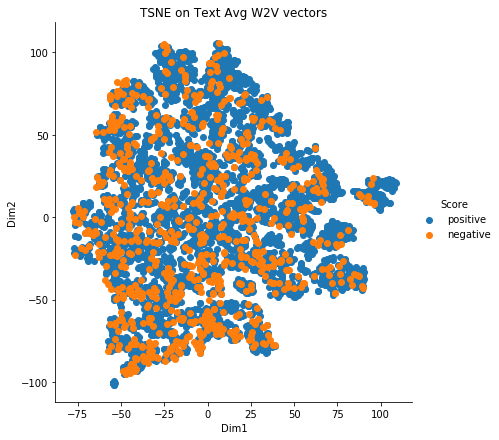

In [118]:
from sklearn.manifold import TSNE
import seaborn as sns
score = final['Score']
model = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=5000)
tsne_data = model.fit_transform(sent_vectors)
tsne_data = np.vstack((tsne_data.T,score)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=("Dim1","Dim2","Score"))

sns.FacetGrid(tsne_df,hue='Score',size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("TSNE on Text Avg W2V vectors")
plt.show()

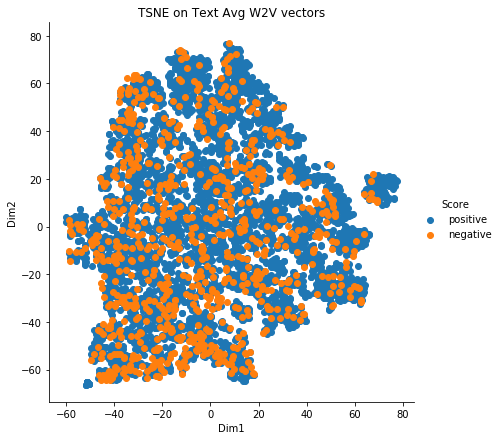

In [122]:
model = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data = model.fit_transform(sent_vectors)
tsne_data = np.vstack((tsne_data.T,score)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=("Dim1","Dim2","Score"))

sns.FacetGrid(tsne_df,hue='Score',size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.title("TSNE on Text Avg W2V vectors")
plt.show()

#### Observation:
Still unable to seperate poritive and negative reviews using TSNE for Avg W2V vectors

### Applying TSNE on Text TFIDF weighted W2V vectors

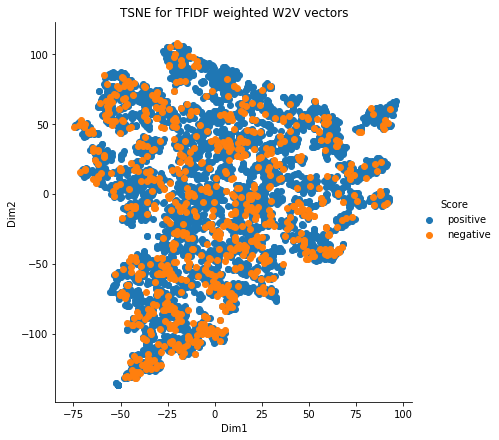

In [123]:
from sklearn.manifold import TSNE
import seaborn as sns
score = final['Score']
model =TSNE(n_components=2,random_state=0,perplexity=30,n_iter=5000)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T,score)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=("Dim1","Dim2","Score"))

sns.FacetGrid(tsne_df,hue='Score',size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("TSNE for TFIDF weighted W2V vectors")
plt.show()

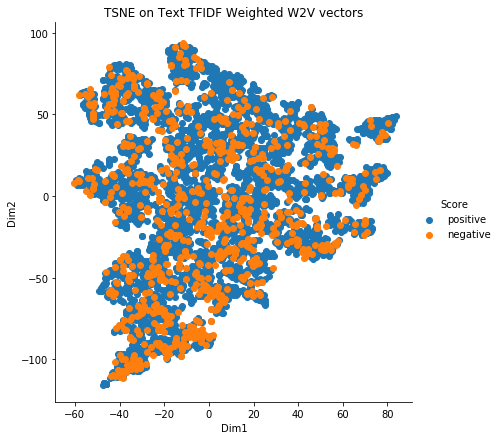

In [125]:
model = TSNE(n_components=2,random_state=0,perplexity=40,n_iter=5000)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T,score)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=("Dim1","Dim2","Score"))

sns.FacetGrid(tsne_df,hue='Score',size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("TSNE on Text TFIDF Weighted W2V vectors")
plt.show()

### Conclusion
We are unable to seperate positive and negative reviews using TSNE.